# Salary Prediction with Regression

Dieses Projekt analysiert einen Gehalts-Datensatz (`K4.0026_2.C.01_Salaries.csv`) 
und nutzt lineare sowie polynomiale Regression, um Gehälter anhand des Levels einer Position vorherzusagen.

## Schritte
- Datenimport und Visualisierung
- Datenreinigung (NaNs, Duplikate, Ausreißer)
- Lineare Regression (mit Korrelationskoeffizient)
- Polynomial Regression (mit K-Fold Cross Validation)
- Vergleich der Modelle (Visualisierung)


# 1.Import all needed libraries for Data Analysis and Visualization


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures



# 2. Data Import and Visualization

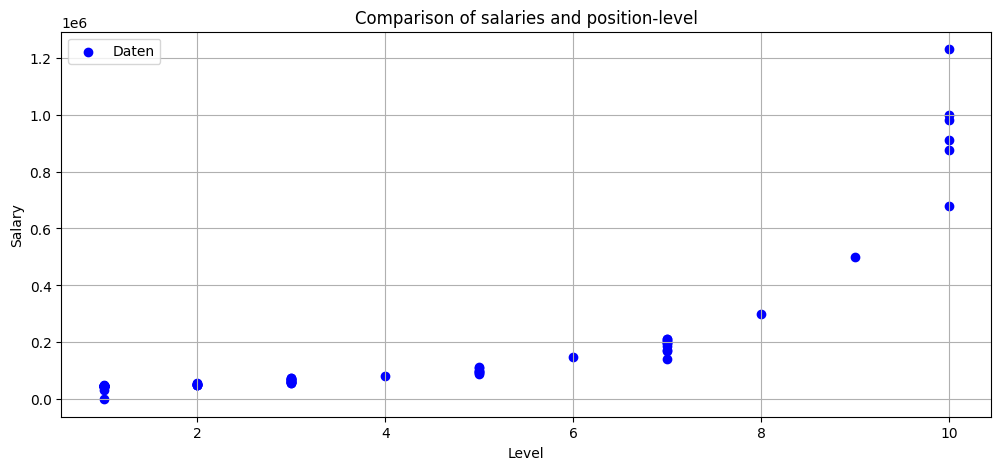

In [4]:
df = pd.read_csv('K4.0026_2.C.01_Salaries.csv')
df.head()
X = df.drop(columns=['Position','Salary'])
y = df['Salary']

plt.figure(figsize=(12,5))

plt.scatter(X,y,color='blue',label='Daten')
plt.title('Comparison of salaries and position-level')
plt.xlabel('Level')
plt.ylabel('Salary')
plt.legend()
plt.grid(True)
plt.show()

# 3. Clear Dataset, remove duplicates, replace NaNs and Outliers with median of Salaries

In [5]:
# Copy Original
df_original = df.copy().reset_index(drop=True)

# ---- Cleanup ----
df_clean = df.copy().reset_index(drop=True)
df_clean.drop_duplicates(inplace=True)

for level in df_clean['Level'].unique():
    subset = df_clean[df_clean['Level'] == level]
    q1 = subset['Salary'].quantile(0.25)
    q3 = subset['Salary'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    median_salary = subset['Salary'].median()

    # replace outliers
    mask_outliers = (df_clean['Level'] == level) & ((df_clean['Salary'] < lower_bound) | (df_clean['Salary'] > upper_bound))
    df_clean.loc[mask_outliers, 'Salary'] = median_salary

    # replace NaNs
    mask_nan = (df_clean['Level'] == level) & (df_clean['Salary'].isna())
    df_clean.loc[mask_nan, 'Salary'] = median_salary
df_clean.reset_index(drop=True,inplace=True)
df_clean


,Position,Level,Salary
0,Business Analyst,1,45000.0
1,Junior Consultant,2,50000.0
2,Senior Consultant,3,60000.0
3,Region Manager,6,150000.0
4,Manager,4,80000.0
...,...,...,...
57,Senior Consultant,3,60630.0
58,Senior Consultant,3,70389.0
59,Senior Consultant,3,66140.0
60,Business Analyst,1,46626.5


# 4. Visualization of the cleanded Dataset

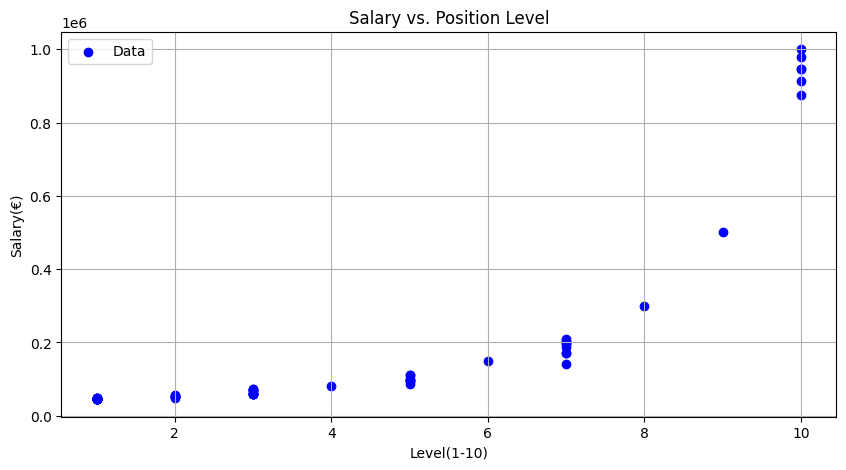

In [6]:
plt.figure(figsize=(10,5))
plt.title('Salary vs. Position Level')
plt.scatter(df_clean['Level'],df_clean['Salary'],color='blue',label='Data')
plt.xlabel('Level(1-10)')
plt.ylabel('Salary(€)')
plt.grid(True)
plt.legend()
plt.show()

# 5. Linear Regression
Coeffecient Value


In [7]:
X = df_clean['Level'].array.reshape(-1,1)
y = df_clean['Salary']

linear_regr = LinearRegression().fit(X,y)
corr = np.corrcoef(df_clean['Level'], df_clean['Salary'])[0,1]
print(f"Korrelationskoeffizient: {corr:.2f}")



Korrelationskoeffizient: 0.81


# 6. K-Fold Cross-Validation


In [8]:
def k_cross_validation(X,y,n_splits=5,maxdegree=4,random_state=42):
    X = np.array(X)
    y = np.array(y).flatten()

    if X.ndim==1 :
        X = X.reshape(-1,1)
    
    # k-folds
    kf = KFold(n_splits=n_splits,shuffle=True,random_state=random_state)
    results = {}
    for degree in range(1,maxdegree+1):
        mse_list = []
        poly = PolynomialFeatures(degree=degree,include_bias=True)
        for train_index, test_index in kf.split(X):
            X_train,X_test,y_train,y_test = X[train_index],X[test_index],y[train_index],y[test_index]
            X_train_poly = poly.fit_transform(X_train)
            X_test_poly = poly.transform(X_test)
            model = LinearRegression().fit(X_train_poly,y_train)
            y_pred = model.predict(X_test_poly)
            mse_list.append(np.mean((y_pred-y_test)**2))
        results[degree] = np.mean(mse_list)
    return results

# 7. Visualize the Linear Regression and the K-Fold Cross Validation

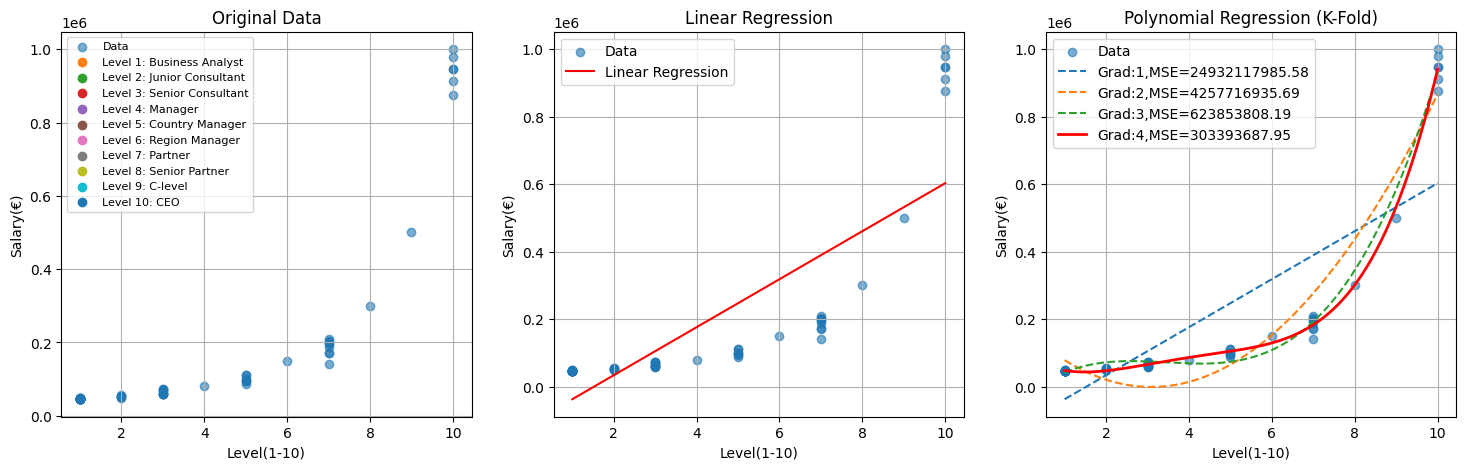

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# 1. plot Data
axs[0].set_title('Original Data')
axs[0].set_xlabel('Level(1-10)')
axs[0].set_ylabel('Salary(€)')
axs[0].scatter(X,y,label='Data',alpha=0.6)
axs[0].grid(True)
axs[0].legend()

# 2. plot linearregression
X_plot = np.linspace(X.min(),X.max(),200).reshape(-1,1)
y_plot = linear_regr.predict(X_plot)
axs[1].set_title('Linear Regression')
axs[1].set_xlabel('Level(1-10)')
axs[1].set_ylabel('Salary(€)')
axs[1].scatter(X,y,label='Data',alpha=0.6)
axs[1].plot(X_plot,y_plot,color='red',label='Linear Regression')
axs[1].grid(True)
axs[1].legend()
# Legend: pro Level
for level in sorted(df_clean['Level'].unique()):
    pos = df_clean[df_clean['Level']==level]['Position'].iloc[0]
    axs[0].scatter([], [], label=f"Level {level}: {pos}")
axs[0].legend(fontsize=8)

# 3. plot K-fold Cross Validation

X_plot = np.linspace(X.min(),X.max(),200).reshape(-1,1)
results = k_cross_validation(X,y)
mse_min = min(results.values())

axs[2].set_title('Polynomial Regression (K-Fold)')
axs[2].set_xlabel('Level(1-10)')
axs[2].set_ylabel('Salary(€)')
axs[2].scatter(X,y,label='Data',alpha=0.6)
for degree in range(1,5):
    poly = PolynomialFeatures(degree=degree,include_bias=True)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly,y)
    y_plot = model.predict(poly.transform(X_plot))
    if mse_min == results[degree]:
        axs[2].plot(X_plot,y_plot,label=f"Grad:{degree},MSE={results[degree]:.2f}",linewidth=2,color = 'red')
    else:
        axs[2].plot(X_plot,y_plot,label=f"Grad:{degree},MSE={results[degree]:.2f}",linestyle='--')
axs[2].grid(True)
axs[2].legend()
plt.show()


